In [1]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"

HOUSING_PATH = os.path.join(os.getcwd(), os.path.join("datasets", "housing"))
print("Housing path:", HOUSING_PATH)

HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)

    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

Housing path: c:\Vansh\PROJECTS\Learning\Machine_Learning\Housing_Price_Prediction\ML_mini_projects\datasets\housing


In [2]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
housing = load_housing_data()
# print(housing.head())
# print(housing.info())
# print(housing["ocean_proximity"].value_counts())
# print(housing.describe())

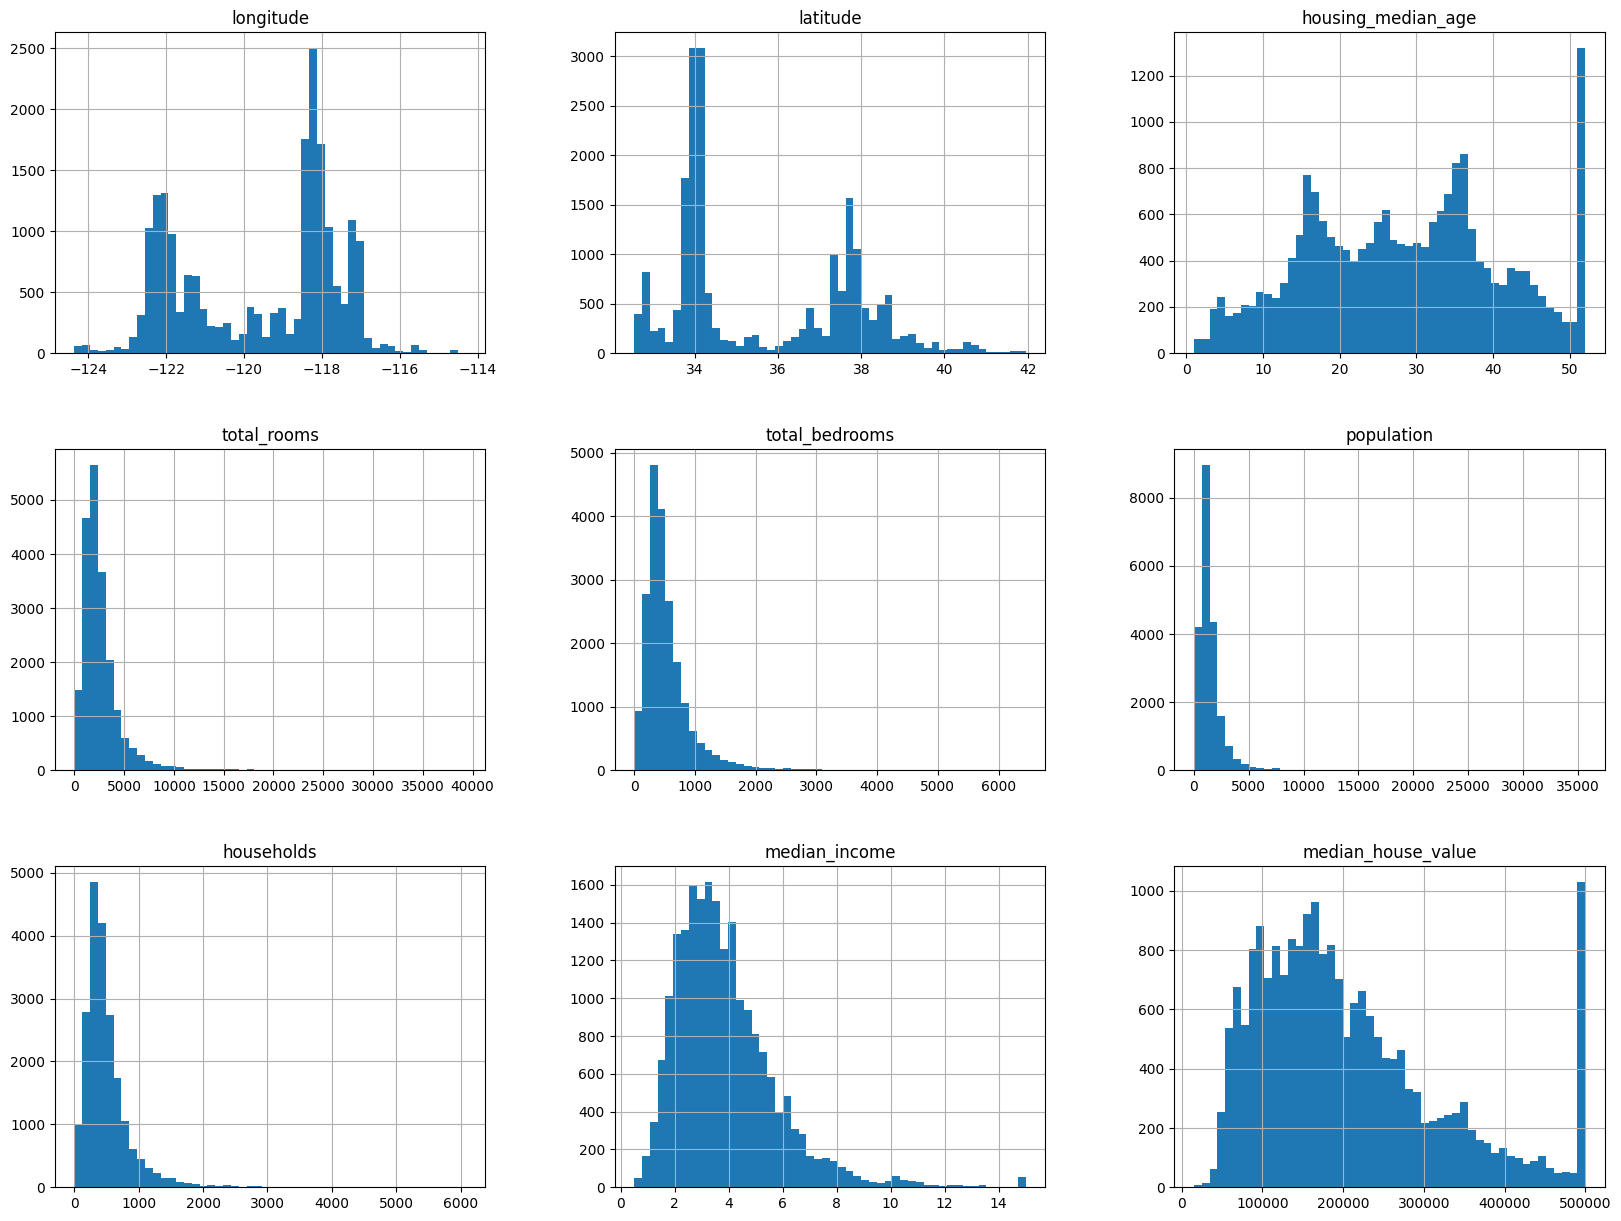

In [4]:
import matplotlib.pyplot as plt

def plot_housing_data(housing):
    housing.hist(bins=50, figsize=(20, 15))
    plt.show()

plot_housing_data(housing)

In [5]:
# from sklearn.model_selection import train_test_split
# train, test = train_test_split(housing, test_size=0.2)
# print(train)

'''
    ---------------------------------------------------------------------------------
    Although train_test_split splitting works well, it may cause problems if data is refreshed latter on, that can lead to training instance and test instance being mixed up.
    On possible solution is using a unique identifer for each of the data instances, and splitting based on those. 
    ---------------------------------------------------------------------------------
    Now, even though splitting data by using hash of instance feature is good, it is necessary to choose a stable feature that doesn't change for that particular instance. This means that using index is a little wonkey.
    ---------------------------------------------------------------------------------
    Maybe using latitude data...
    ---------------------------------------------------------------------------------
    Or just use the one provided by sklearn
    ---------------------------------------------------------------------------------
'''
import numpy as np

def train_test_split(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(test_ratio * len(data))
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = train_test_split(housing, 0.2)

from zlib import crc32 #(2)

def test_set_check(identifier, test_ratio):                                 #(2)
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_:test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]



<Axes: >

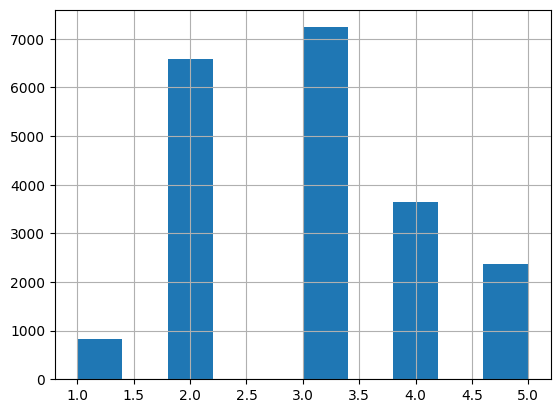

In [6]:
housing ["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5])
housing["income_cat"].hist()

In [7]:
'''
When some features are more important than others, we need to make sure that the test class does represent the original data in terms of the weight of various classes....
'''

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace = True)

In [8]:
# housing_with_id = housing.reset_index() #(2)
# housing_with_id["id"] = housing["longitude"]*1000 + housing["latitude"] #(3)
# train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

train_set = pd.DataFrame(strat_train_set.copy())

<Axes: xlabel='longitude', ylabel='latitude'>

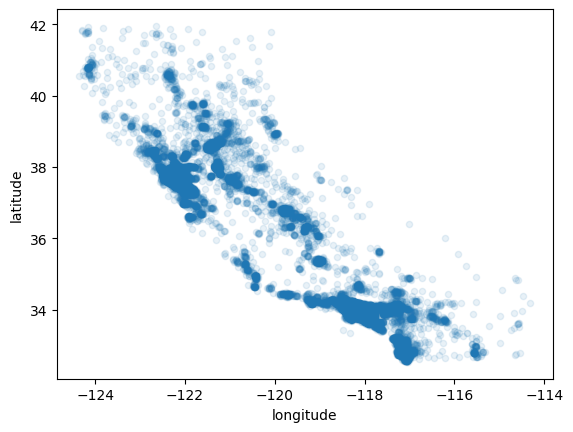

In [9]:
train_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

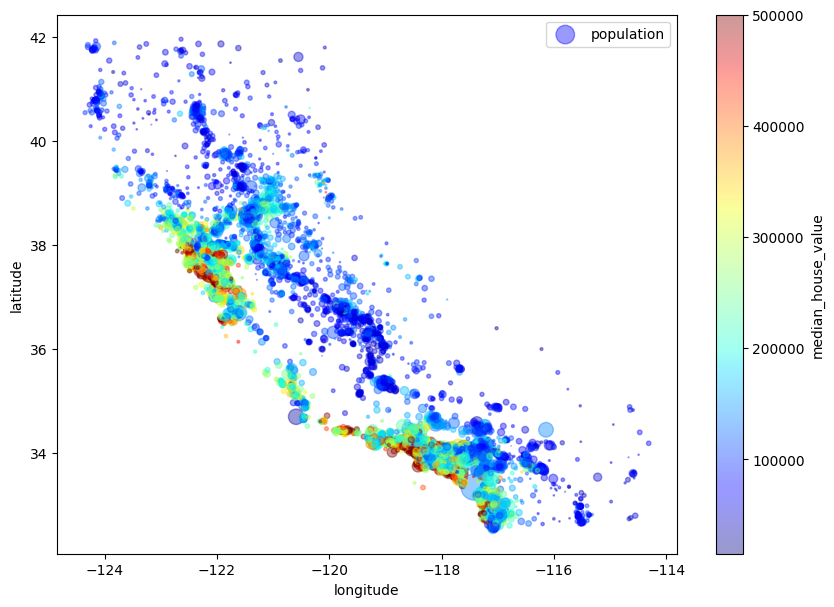

In [10]:
train_set.plot(
    kind="scatter", 
    x="longitude", 
    y="latitude", 
    alpha=0.4, 
    s=(train_set["population"]/100), 
    label="population", 
    figsize=(10,7), 
    c="median_house_value", 
    cmap=plt.get_cmap("jet"), 
    colorbar=True,
    )
plt.legend()

In [11]:
# train_set.drop("ocean_proximity")
corr_matrix = train_set.corr(method="pearson", numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

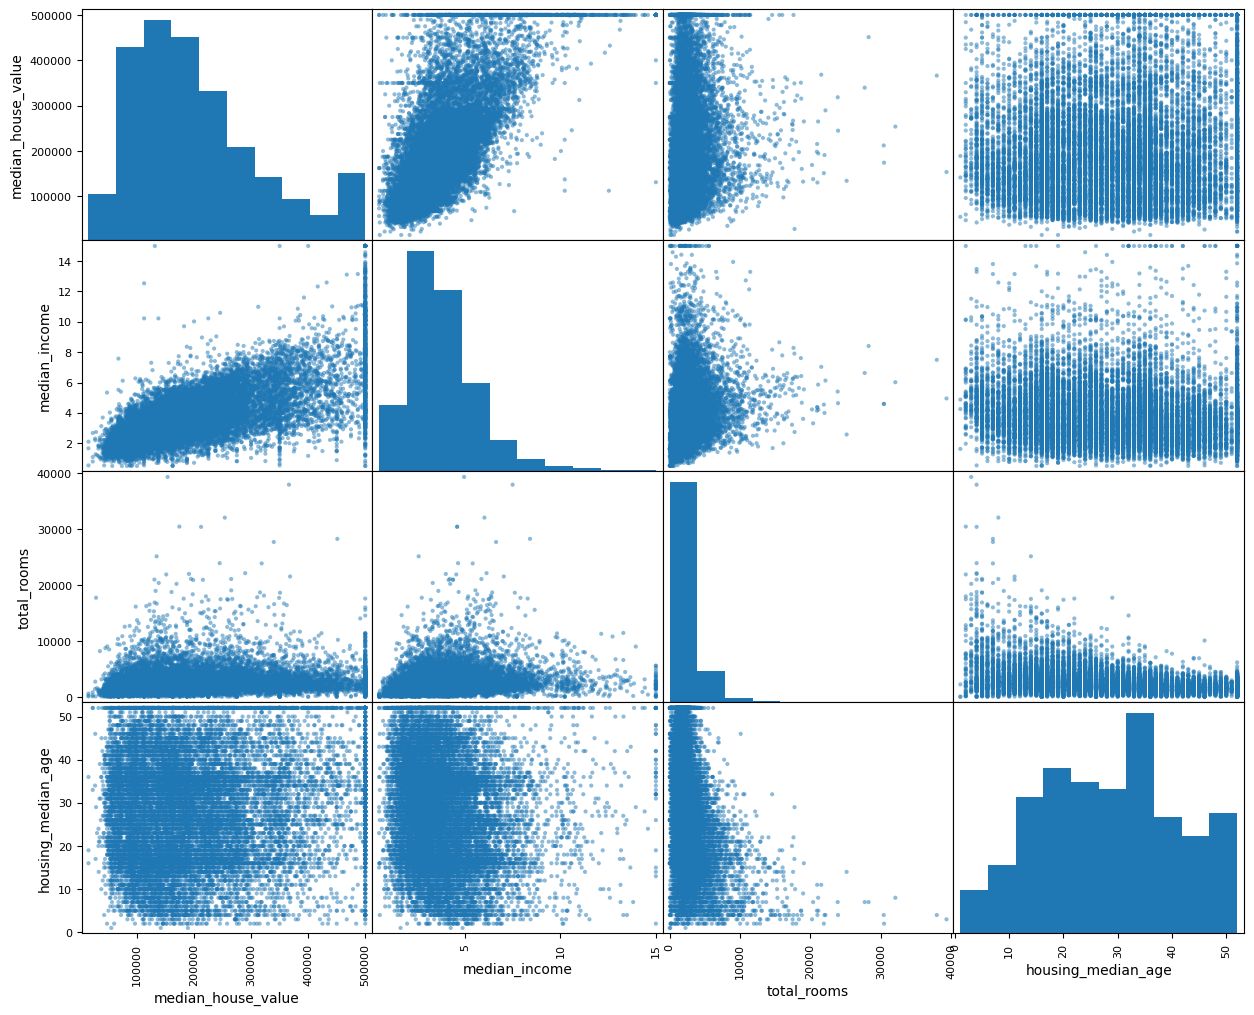

In [12]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(train_set[attributes], figsize=(15,12))

<Axes: xlabel='median_income', ylabel='median_house_value'>

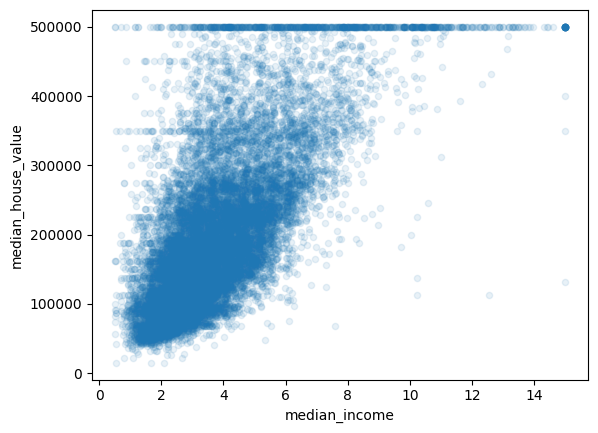

In [13]:
train_set.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [14]:
'''
    ---------------------------------------------------------------------------------
    Sometimes, the relationship betweem variables is not linear, and we need to transform the data to make it linear.
    ---------------------------------------------------------------------------------
    There are also times, when a combination of features can give us a better insight into the data.
    ---------------------------------------------------------------------------------
    Now, we can see that there is a strong correlation between median_income and median_house_value, but it is not linear.
    ---------------------------------------------------------------------------------
    We can also see that there are some outliers in the data, which we will need to deal with later.
    ---------------------------------------------------------------------------------
'''

train_set["rooms_per_household"] = train_set["total_rooms"] / train_set["households"]
train_set["bedrooms_per_room"] = train_set["total_bedrooms"] / train_set["total_rooms"]
train_set["population_per_household"] = train_set["population"] / train_set["households"]

In [15]:
corr_matrix = train_set.corr(method="pearson", numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

In [16]:
train_set = strat_train_set.drop("median_house_value", axis=1)
train_set_labels = strat_train_set["median_house_value"].copy()

In [17]:
'''
train_set.dropna(subset=["total_bedrooms"], inplace=True)   # option 1: drop the rows with missing values in specified column(s).
train_set.drop("total_bedrooms", axis=1, inplace=True)      # option 2: drop the whole column with missing values.

median = train_set["total_bedrooms"].median()
train_set["total_bedrooms"].fillna(median, inplace=True)    # option 3: fill the missing values with the median of the column.
'''

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
train_set_num_only = train_set.drop("ocean_proximity", axis=1)

'''
    ---------------------------------------------------------------------------------
    The SimpleImputer class is used to fill in missing values in the data. It can be used to fill in missing values with the mean, median, or most frequent value.
    ---------------------------------------------------------------------------------
    The strategy parameter can be set to "mean", "median", "most_frequent", or "constant".
    ---------------------------------------------------------------------------------
    The fit method is used to train the imputer on the data, and then the transform method is used to fill in the missing values.
    ---------------------------------------------------------------------------------
'''
imputer.fit(train_set_num_only)
# print("Imputer statistics:", imputer.statistics_)
X = imputer.transform(train_set_num_only)
housing_tr = pd.DataFrame(X, columns=train_set_num_only.columns)

In [18]:
'''
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat = housing[["ocean_proximity"]]
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
ordinal_encoder.categories_  # This will show the categories in the order they were encoded
'''

'''
    ----------------------------------------------------------------------------------
    Although the OrdinalEncoder is used to convert categorical data into numerical data, it is important to note that this method assumes an ordinal relationship between the categories. This categories 1 and 2 are considered to be more similar than categories 1 and 3, for example. If this is not the case, then it is better to use OneHotEncoder.
    ----------------------------------------------------------------------------------
'''

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder()
housing_cat = housing[["ocean_proximity"]]
housing_cat_1hot = one_hot_encoder.fit_transform(housing_cat)

housing_cat_1hot # This will be a sparse matrix, this is a memory-efficient way to store the data

# To convert it to a dense array, you can use the toarray() method
# housing_cat_1hot_dense = housing_cat_1hot.toarray()

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 20640 stored elements and shape (20640, 5)>

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [20]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

# housing_num_tr = num_pipeline.fit_transform(train_set_num_only)

In [21]:
from sklearn.compose import ColumnTransformer

train_set_num_only = train_set.drop("ocean_proximity", axis=1)

num_attribs = list(train_set_num_only)
cat_attribs = list(["ocean_proximity"])

fullpipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

train_set_prepared = fullpipeline.fit_transform(train_set)

# Learning to Train and Predict using Linear Regression Model

In [22]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_set_prepared, train_set_labels)

LinearRegression()

In [23]:
some_data = train_set[:5]
some_labels = train_set_labels[:5]

some_data_prepared = fullpipeline.transform(some_data)
predictions = lin_reg.predict(some_data_prepared)
print("Predictions:", predictions)
print("Labels:", list(some_labels))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [24]:
from sklearn.metrics import mean_squared_error

predictions = lin_reg.predict(train_set_prepared)
lin_mse = mean_squared_error(train_set_labels, predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_mse)

4709785076.060029


^^^^

Model Underfit

# Trying out Decision Trees

In [25]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(train_set_prepared, train_set_labels)

DecisionTreeRegressor()

In [26]:
predictions = tree_reg.predict(train_set_prepared)
tree_mse = mean_squared_error(train_set_labels, predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

0.0


^^^^

Model Overfit


# Learning Validation

In [27]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, train_set_prepared, train_set_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
print("Tree RMSE scores:", tree_rmse_scores)

Tree RMSE scores: [73533.4555123  70910.1224126  68350.75785519 70562.5996609
 68158.58236234 77556.3330665  69826.84221821 74528.95057585
 68602.11974385 71589.79983473]


In [28]:
def display_scores(scores):
    print("Score:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

display_scores(tree_rmse_scores)

Score: [73533.4555123  70910.1224126  68350.75785519 70562.5996609
 68158.58236234 77556.3330665  69826.84221821 74528.95057585
 68602.11974385 71589.79983473]
Mean: 71361.95632424942
Standard Deviation: 2886.395613761893


In [29]:
lin_scores = cross_val_score(lin_reg, train_set_prepared, train_set_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)


Score: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard Deviation: 2880.3282098180666


# Trying out Random Forest Ensamble Learning

In [30]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(train_set_prepared, train_set_labels)

predictions = forest_reg.predict(train_set_prepared)
forest_mse = mean_squared_error(train_set_labels, predictions)
forest_rmse = np.sqrt(forest_mse)

print("Forest RMSE:", forest_rmse)

Forest RMSE: 18703.643045576464


In [31]:
forest_scores = cross_val_score(forest_reg, train_set_prepared, train_set_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Score: [51181.84428568 49017.29282048 46819.19951538 52071.95447195
 47629.70263942 51861.5666435  52142.6656402  50030.0830276
 48123.11716202 53603.74022094]
Mean: 50248.11664271841
Standard Deviation: 2152.7338766477806


Since the error increases heavily during cross validation, it is possible that the ensamble learning model still overfits 

# Saving the model progress

In [32]:
import joblib

def save_model(model, filename):
    joblib.dump(model, filename)

def load_model(filename):
    return joblib.load(filename)

## Fine Tuning the Model

GridSearchCV

In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

grid_search = GridSearchCV(
    forest_reg, param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    return_train_score=True
    )

grid_search.fit(train_set_prepared, train_set_labels)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [34]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [35]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [36]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

65168.01879896187 {'max_features': 2, 'n_estimators': 3}
55573.04504762464 {'max_features': 2, 'n_estimators': 10}
52620.97870083689 {'max_features': 2, 'n_estimators': 30}
60373.04833441149 {'max_features': 4, 'n_estimators': 3}
52649.33453133165 {'max_features': 4, 'n_estimators': 10}
50375.07379111173 {'max_features': 4, 'n_estimators': 30}
59962.96598556467 {'max_features': 6, 'n_estimators': 3}
52369.323039988296 {'max_features': 6, 'n_estimators': 10}
49911.38577340519 {'max_features': 6, 'n_estimators': 30}
58935.93977315843 {'max_features': 8, 'n_estimators': 3}
52215.149387403086 {'max_features': 8, 'n_estimators': 10}
50093.27360481694 {'max_features': 8, 'n_estimators': 30}
62462.04968685976 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54271.41261449114 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59870.77315241838 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52791.24506420779 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

Other methods: RandomizedSearchCV

# Checking out the importance of various features

In [37]:
feature_importances = grid_search.best_estimator_.feature_importances_
print("Feature importances:", feature_importances)

Feature importances: [7.36949025e-02 6.45177126e-02 4.34454287e-02 1.77750766e-02
 1.77275647e-02 1.70221031e-02 1.61349682e-02 3.22362354e-01
 6.24594241e-02 1.06102773e-01 9.13495685e-02 8.04763392e-03
 1.51990764e-01 1.07307630e-04 2.48304260e-03 4.77937579e-03]


In [38]:
extra_attribs = ['rooms_per_household', 'population_per_household', 'bedrooms_per_room']
cat_encoder = fullpipeline.named_transformers_['cat']
cat_one_hot = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot

sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.32236235440906597), 'median_income'),
 (np.float64(0.15199076380769652), 'INLAND'),
 (np.float64(0.10610277285407278), 'population_per_household'),
 (np.float64(0.09134956848159662), 'bedrooms_per_room'),
 (np.float64(0.07369490248980495), 'longitude'),
 (np.float64(0.06451771264244893), 'latitude'),
 (np.float64(0.062459424085789424), 'rooms_per_household'),
 (np.float64(0.04344542869152757), 'housing_median_age'),
 (np.float64(0.01777507657522962), 'total_rooms'),
 (np.float64(0.01772756472491641), 'total_bedrooms'),
 (np.float64(0.01702210312158939), 'population'),
 (np.float64(0.016134968178395562), 'households'),
 (np.float64(0.00804763391754684), '<1H OCEAN'),
 (np.float64(0.004779375789106897), 'NEAR OCEAN'),
 (np.float64(0.002483042601676448), 'NEAR BAY'),
 (np.float64(0.00010730762953611032), 'ISLAND')]

In [39]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
X_test_labels = strat_test_set["median_house_value"].copy()
X_test_prepared = fullpipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(X_test_labels, final_predictions)
final_rmse = np.sqrt(final_mse)

print("Final RMSE:", final_rmse)

Final RMSE: 48131.10352439012


In [40]:
from scipy import stats
confidence = 0.95
sqaured_errors = (final_predictions - X_test_labels) ** 2
np.sqrt(stats.t.interval(
    confidence,
    len(sqaured_errors) - 1,
    loc= sqaured_errors.mean(),
    scale= stats.sem(sqaured_errors)
))

array([46109.97315216, 50070.71628066])